# Combining and analyzing neural recordings
This script will take individual fiber photometry recording sessions (up to a few hours each) and 1) combine them and 2) perform analysis of the combined data.

The individual trials should be together in a directory as .pkl files (output from "Single_Trial_Analysis.ipynb"), each file name beginning with 'Data_'.

This script outputs a .pkl file containing the merged data ('AllTrialsData.pkl'), and several graphs.

As measures of activity, this script uses both dF/F0 (change in activity relative to pre-stimulus period) and z-scored dF/F0 (i.e. normalized to pre-stimulus signal variance).

In [1]:
# Import libraries
from tkinter.filedialog import askdirectory
from tkinter import Tk
import os
import pickle
from os import listdir
import pandas as pd
import numpy as np
from os.path import isfile, join
import matplotlib.pyplot as plt
import scipy.stats
from matplotlib import colors

############################################################
# Set these parameters to determine trial duration

trialTime = 30 #set trial time to take in  - must be more than PreTime+PostTime
F0PreTime = 4 #mins before drop to take as F0 - will exclude 15s before drop
PreTime = 4 #mins before drop to plot
PostTime = 24 #mins after drop to plot
DS_rate = 10 #standard sampling rate of input data
############################################################

# Convert trial duration values to seconds
trialTime = trialTime*60
F0PreTime = F0PreTime*60
PreTime = PreTime*60
PostTime = PostTime*60

plt.rcParams['figure.figsize'] = [9,10.5] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.
plt.rcParams.update({'font.size': 16})

In [2]:
# Open a dialog box to select the directory to be analyzed
window = Tk()
window.wm_attributes('-topmost', 1)
window.withdraw()
Dir2 = askdirectory(parent = window)
os.chdir(Dir2 + '/')


# List all files in directory
onlyfiles = [f for f in listdir(Dir2) if isfile(join(Dir2, f))]

# Find .pkl files containing 'Data_'
pklFiles=[]
for i in range(len(onlyfiles)):
    if onlyfiles[i].find('Data_')>-1 and onlyfiles[i].find('.pkl')>-1:
        pklFiles.append(onlyfiles[i])

### Create 'AllTrials' dict, and dataframes within, to contain merged data
# Initialize 'AllTrials' dictionary
AllTrials = {'GCaMP_corrected':[], 'Ch1_Filt':[],'Ch2_Filt':[],
'DropTimes':[],'ContactTimes':[],'BiteTimes':[],'FinishTimes':[],
'BoutStarts':[],'BoutEnds':[],'DropWhat':[],'MouseID':[],'TrialID':[],
'Drop_dFF0':[], 'dFF0_Ch1Filt':[], 'dFF0_Ch2Filt':[]}

# Create dataframes for each key that will contain recorded signals
# First determine indices (timestamps) for 'raw data'
dataRange1 = [np.round(x/DS_rate,1) for x in list(range(0,trialTime*DS_rate))] # each value in list = time in seconds
# And for dF/F0 traces to be calculated (relative to "drop")
dFF0range1 = [np.round(x,1) for x in np.arange(0 - PreTime, PostTime, 1/DS_rate)] # correct for 
# Initialize multiindex
my_cols = pd.MultiIndex(levels = [[],[],[],[]],
                            codes = [[],[],[],[]],
                            names = [u'MouseID',u'TrialID',u'DropWhat',u'DropTime']
                            )

# Create dataframes
AllTrials['GCaMP_corrected'] = pd.DataFrame(index = dataRange1, columns = my_cols)
AllTrials['Ch1_Filt'] = pd.DataFrame(index = dataRange1, columns = my_cols)
AllTrials['Ch2_Filt'] = pd.DataFrame(index = dataRange1, columns = my_cols)
AllTrials['Drop_dFF0'] = pd.DataFrame(index = dFF0range1, columns = my_cols)
AllTrials['dFF0_Ch1Filt'] = pd.DataFrame(index = dFF0range1, columns = my_cols)
AllTrials['dFF0_Ch2Filt'] = pd.DataFrame(index = dFF0range1, columns = my_cols)
AllTrials['Drop_ZS'] = pd.DataFrame(index = dFF0range1, columns = my_cols)
AllTrials['ZS_Ch1'] = pd.DataFrame(index = dFF0range1, columns = my_cols)
AllTrials['ZS_Ch2'] = pd.DataFrame(index = dFF0range1, columns = my_cols)

### Loop through files (=trials) and add data from each to the AllTrials dict
# Also calculate dF/F0 relative to drop event and Z-scored dF/F0
trial=0
for i in pklFiles:
    with open(i, 'rb') as f:
        trial = trial+1
        TrialData = pickle.load(f)
        # Find MouseID and TrialID from the file name
        MouseID = i[i.find('_')+1:i.find('-')]
        TrialID = i[i.find('-')+1:i.rfind('.')]
        # Each signal type (filtered, corrected and dF/F0) will be saved in a dataframe
        # where rows correspond to timepoints, and each column = one trial
        # Column names will have multiple values - MouseID,TrialID,food name and food drop time
        cols1 = pd.MultiIndex.from_arrays([[MouseID],[TrialID],[TrialData['DropWhat']],[TrialData['DropTimes']/TrialData['DSrate']]])
        # Limit trial length to the duration defined above
        dataRange=list(range(0,trialTime*TrialData['DSrate'])) #  each value in list = sample number
        dataRange1=[x/TrialData['DSrate'] for x in dataRange] # each value in list = time in seconds

        # Create dataframes with GCaMP_corrected, Ch1 and Ch2 signals to be added to AllTrials (in case DSrate is different)
        GC_add = pd.DataFrame(TrialData['GCaMP_corrected'][dataRange], index = dataRange1, columns = cols1)
        Ch1_add = pd.DataFrame(TrialData['Ch1_Filt'][dataRange], index = dataRange1, columns = cols1)
        Ch2_add = pd.DataFrame(TrialData['Ch2_Filt'][dataRange], index = dataRange1, columns = cols1)
        # Add to AllTrials dataframe
        AllTrials['GCaMP_corrected'] = pd.concat([AllTrials['GCaMP_corrected'],GC_add], axis=1)
        AllTrials['Ch1_Filt'] = pd.concat([AllTrials['GCaMP_corrected'],Ch1_add], axis=1)
        AllTrials['Ch2_Filt'] = pd.concat([AllTrials['GCaMP_corrected'],Ch2_add], axis=1)
        
        ##### Now calculate dFF0 wrt first drop on this trial for corrected data, Ch1 & Ch2
        DropTime = list(cols1.get_level_values(3))[0]
        # Determine samples to use to calculate F0
        F0range = np.arange(DropTime - F0PreTime, DropTime - 1, 1/TrialData['DSrate'])
        F0range = [round(j,1) for j in F0range] # correct for floating point errors
        # Calculate F0 for each signal type
        F0_corr = np.mean(GC_add.loc[F0range].values) #for corrected data
        F0_Ch1 = np.mean(Ch1_add.loc[F0range].values) #for Ch1
        F0_Ch2 = np.mean(Ch2_add.loc[F0range].values) #for Ch2

        # Determine samples to use for dF/F0
        dFF0range = np.arange(DropTime - PreTime, DropTime + PostTime, 1/TrialData['DSrate']) # in samples
        dFF0range = [np.round(j,1) for j in dFF0range] # correct for floating point errors
        dFF0range1 = [np.round(x-DropTime,1) for x in dFF0range] # in time relative to drop
        # Calculate dF/F0
        dFF0_corr_add = pd.DataFrame((GC_add.loc[dFF0range].values - F0_corr)/F0_corr, 
                                        index = dFF0range1, columns = cols1)
        dFF0_Ch1_add = pd.DataFrame((Ch1_add.loc[dFF0range].values - F0_Ch1)/F0_Ch1, 
                                        index = dFF0range1, columns = cols1)
        dFF0_Ch2_add = pd.DataFrame((Ch2_add.loc[dFF0range].values - F0_Ch2)/F0_Ch2, 
                                        index = dFF0range1, columns = cols1)
        

        
        # Add to AllTrials
        AllTrials['Drop_dFF0'] = pd.concat([AllTrials['Drop_dFF0'],dFF0_corr_add], axis=1)
        AllTrials['dFF0_Ch1Filt'] = pd.concat([AllTrials['dFF0_Ch1Filt'],dFF0_Ch1_add], axis=1)
        AllTrials['dFF0_Ch2Filt'] = pd.concat([AllTrials['dFF0_Ch2Filt'],dFF0_Ch2_add], axis=1)
        
        # Calculate z-scored dF/F0
        ZS_corr_add = dFF0_corr_add / np.std(dFF0_corr_add.loc[:-1.0])
        ZS_Ch1_add = dFF0_Ch1_add / np.std(dFF0_Ch1_add.loc[:-1.0])
        ZS_Ch2_add = dFF0_Ch2_add / np.std(dFF0_Ch2_add.loc[:-1.0])
        # Add to AllTrials
        AllTrials['Drop_ZS'] = pd.concat([AllTrials['Drop_ZS'], ZS_corr_add], axis=1)
        AllTrials['ZS_Ch1'] = pd.concat([AllTrials['ZS_Ch1'], ZS_Ch1_add], axis=1)
        AllTrials['ZS_Ch2'] = pd.concat([AllTrials['ZS_Ch2'], ZS_Ch2_add], axis=1)

        # delete unnecessary variables
        del(F0range,F0_corr,F0_Ch1,F0_Ch2,dFF0range,dFF0range1,dFF0_corr_add,dFF0_Ch1_add,dFF0_Ch2_add,
        ZS_corr_add,ZS_Ch1_add,ZS_Ch2_add)


        # Now add event annotations to AllTrials
                                        
        if 'DropTimes' in TrialData.keys():
            AllTrials['DropTimes'].append(TrialData['DropTimes'])
        else:
            AllTrials['DropTimes'].append(np.nan)
        if 'ContactTimes' in TrialData.keys():
            AllTrials['ContactTimes'].append(TrialData['ContactTimes'])
        else:
            AllTrials['ContactTimes'].append(np.nan)
        if 'BiteTimes' in TrialData.keys():
            AllTrials['BiteTimes'].append(TrialData['BiteTimes'])
        else:
            AllTrials['BiteTimes'].append(np.nan)
        if 'FinishTimes' in TrialData.keys():
            AllTrials['FinishTimes'].append(TrialData['FinishTimes'])
        else:
            AllTrials['FinishTimes'].append(np.nan)
        if 'BoutStarts' in TrialData.keys():
            AllTrials['BoutStarts'].append(TrialData['BoutStarts'])
        else:
            AllTrials['BoutStarts'].append(np.nan)
        if 'BoutEnds' in TrialData.keys():
            AllTrials['BoutEnds'].append(TrialData['BoutEnds'])
        else:
            AllTrials['BoutEnds'].append(np.nan)
        if 'DropWhat' in TrialData.keys():
            AllTrials['DropWhat'].append(TrialData['DropWhat'])
        else:
            AllTrials['DropWhat'].append(np.nan)
        
        # Add MouseID and TrialID to respective keys
        AllTrials['MouseID'].append(MouseID)
        AllTrials['TrialID'].append(TrialID)
        # delete unnecessary variables
        del(MouseID,TrialID,dataRange,dataRange1,cols1,TrialData)
        
# Save AllTrials dict to a .pkl file
f = open('AllTrialsData.pkl',"wb")
pickle.dump(AllTrials,f)
f.close()

# Analyze merged data
The analysis code below can be run independently of the merging code above

In [3]:
###############################
# Define which stimuli to plot:
StimsToPlot = ['chow', 'marb']
DS = 10 #how much to downsample for plots
###############################
# Set these variables to determine how long before each event type to plot
ContactPreTime = 3 #in mins
BitePreTime = 3 #in mins
FinishPreTime = 5 #in mins
###############################

# Convert to seconds
ContactPreTime = ContactPreTime*60
FinishPreTime = FinishPreTime*60
BitePreTime = BitePreTime*60

# Open a dialog box to select the directory to be analyzed
# (so that this code block can be run independently of the merging block above)
window = Tk()
window.wm_attributes('-topmost', 1)
window.withdraw()
Dir2 = askdirectory(parent = window)
os.chdir(Dir2 + '/')

# Load data
with open('AllTrialsData.pkl', 'rb') as f:
    AllTrials = pickle.load(f)

Calculate mean over trials **for each mouse** separately, for each stimulus (food) type

In [4]:
# Initialize dataframe to contain mouse means (for dF/F0 AND z-score)
my_cols = pd.MultiIndex(levels = [[],[]], codes = [[],[]],
                            names = [u'Mouse',u'Stim'])
MouseMeans_Aligned = {}
MouseMeans_Aligned['dFF0'] = {}
MouseMeans_Aligned['dFF0']['Drop'] = pd.DataFrame(index = AllTrials['Drop_dFF0'].index, columns = my_cols)
MouseMeans_Aligned['ZS'] = {}
MouseMeans_Aligned['ZS']['Drop'] = pd.DataFrame(index = AllTrials['Drop_dFF0'].index, columns = my_cols)

for Mouse in list(set(AllTrials['MouseID'])): #loop through mice
    MouseTrials_dFF0 = AllTrials['Drop_dFF0'].xs(Mouse, level=0, axis=1) # take the trials from this mouse
    MouseTrials_ZS = AllTrials['Drop_ZS'].xs(Mouse, level=0, axis=1)
    # loop through unique stimulus IDs for this mouse
    for Stim in list(set(MouseTrials_dFF0.columns.get_level_values(1))):
        # return the trials for this stimulus
        ThisStimTrials_dFF0 = MouseTrials_dFF0.xs(Stim, level=1, axis=1)
        ThisStimTrials_ZS = MouseTrials_ZS.xs(Stim, level=1, axis=1)
        # calculate mean over trials for this mouse
        ThisMouseMean_dFF0 = pd.DataFrame(np.mean(ThisStimTrials_dFF0,1), 
                                                index=list(MouseTrials_dFF0.index), columns=pd.MultiIndex.from_arrays([[Mouse],[Stim]]))
        ThisMouseMean_ZS = pd.DataFrame(np.mean(ThisStimTrials_ZS,1), 
                                                index=list(MouseTrials_ZS.index), columns=pd.MultiIndex.from_arrays([[Mouse],[Stim]]))
        # add to dataframe
        MouseMeans_Aligned['dFF0']['Drop'] = pd.concat([MouseMeans_Aligned['dFF0']['Drop'],ThisMouseMean_dFF0], axis=1)
        MouseMeans_Aligned['ZS']['Drop'] = pd.concat([MouseMeans_Aligned['ZS']['Drop'],ThisMouseMean_ZS], axis=1)
        del(ThisMouseMean_dFF0,ThisMouseMean_ZS,ThisStimTrials_dFF0,ThisStimTrials_ZS)
    del(MouseTrials_dFF0,MouseTrials_ZS)

In [5]:
# Create function to plot mean trace for each mouse, with separate plot for each stimulus type, given dataframe as input
# Other arguments are the stimuli to be plotted ('Stims') and a string defining the signal and event being aligned to ('Signal')

def Plot_Per_Mouse(Stims, Signal, AlignedTo, MouseData = MouseMeans_Aligned):
    # create figure - separate axes for each stimulus type
    fig, axs = plt.subplots(len(Stims), 1)
    MouseData = MouseMeans_Aligned[Signal][AlignedTo]
    # loop through unique stimulus types
    StimN = 0
    for Stim in Stims:
        # plot traces for each mouse for this stimulus
        This_Stim_Traces = MouseData.xs(Stim, level=1, axis=1)
        This_Stim_Traces.plot(ax=axs[StimN])
        # plot line at t=0
        axs[StimN].plot([0,0], [MouseData.min().min(), MouseData.max().max()])
        # set axis properties
        axs[StimN].set(ylabel = Signal,
                        title = Signal + ' '+AlignedTo+'Aligned' + ', stimulus = ' + Stim,
                        ylim = [MouseData.min().min(), MouseData.max().max()])
        axs[StimN].set_xlabel("time (s) from " + AlignedTo, labelpad=-40)
        axs[StimN].legend(loc = "upper right")
        StimN = StimN + 1
    # save figure
    fig.savefig('MeanTraces_PerMouse ' + Signal + ' ' + AlignedTo+'Aligned.png')

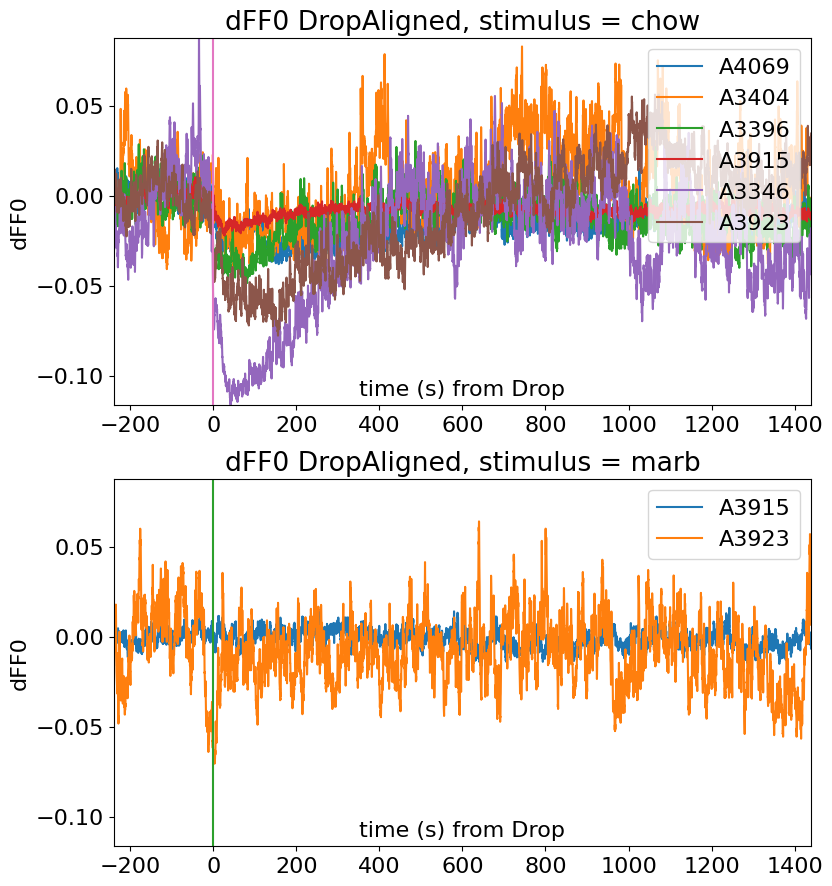

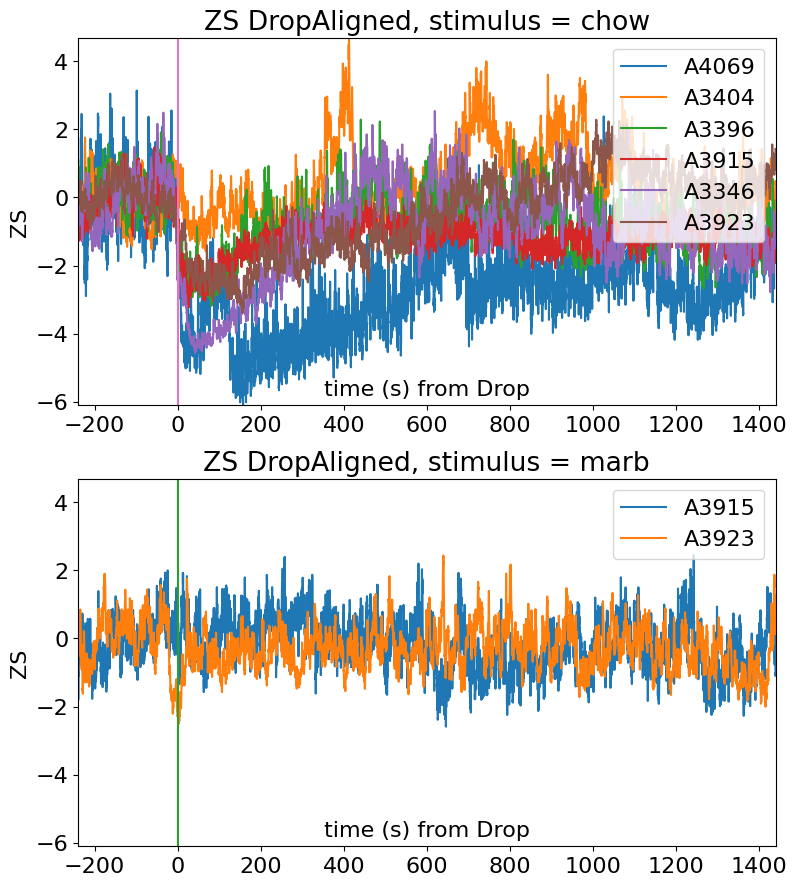

In [6]:
Plot_Per_Mouse(Stims = StimsToPlot, Signal = 'dFF0', AlignedTo = 'Drop')
Plot_Per_Mouse(Stims = StimsToPlot, Signal = 'ZS', AlignedTo = 'Drop')

Plot mean over trials for each stimulus.

In [9]:
# Create function that will plot mean over trials for each stimulus given a dataframe as input
# Other arguments are the stimuli to be plotted ('Stims') and a string defining the signal and event being aligned to ('Signal')

def Plot_Mean_Over_Trials(Stims, Signal, AlignedTo, TrialData = AllTrials):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    TrialData = TrialData[AlignedTo+'_'+Signal]
    for Stim in Stims:
        # Select trials for this stimulus
        StimTrials = TrialData.xs(Stim, level = 2, axis = 1)
        # Calculate mean over these trials and downsample
        StimMean = np.mean(StimTrials, 1)[::DS]
        # Calculate SEM and downsample
        StimSEM = np.std(StimTrials,1,ddof=1) / np.sqrt(len(StimTrials.columns))
        StimSEM = StimSEM[::DS]
        # Shade in SEM
        ax.fill_between(np.array(StimMean.index,dtype=float), np.add(StimMean,StimSEM).tolist(),
                            np.subtract(StimMean,StimSEM).tolist(),
                            alpha = 0.4)
        # Plot mean trace
        ax.plot(StimMean, label = Stim)
    # Plot line at t=0
    yl = list(ax.get_ylim())
    ax.plot([0,0],yl,color='r')
    ax.set_ylim(yl)
    ax.legend(loc="lower right")
    ax.set_xlabel('time (secs)')
    ax.set_ylabel(Signal)
    ax.set_title('Mean over trials - aligned to '+AlignedTo)

    # Save this figure
    fig.savefig(Signal+' '+AlignedTo+'Aligned' + ', '.join(StimsToPlot)+': MeanOverTrials.png')

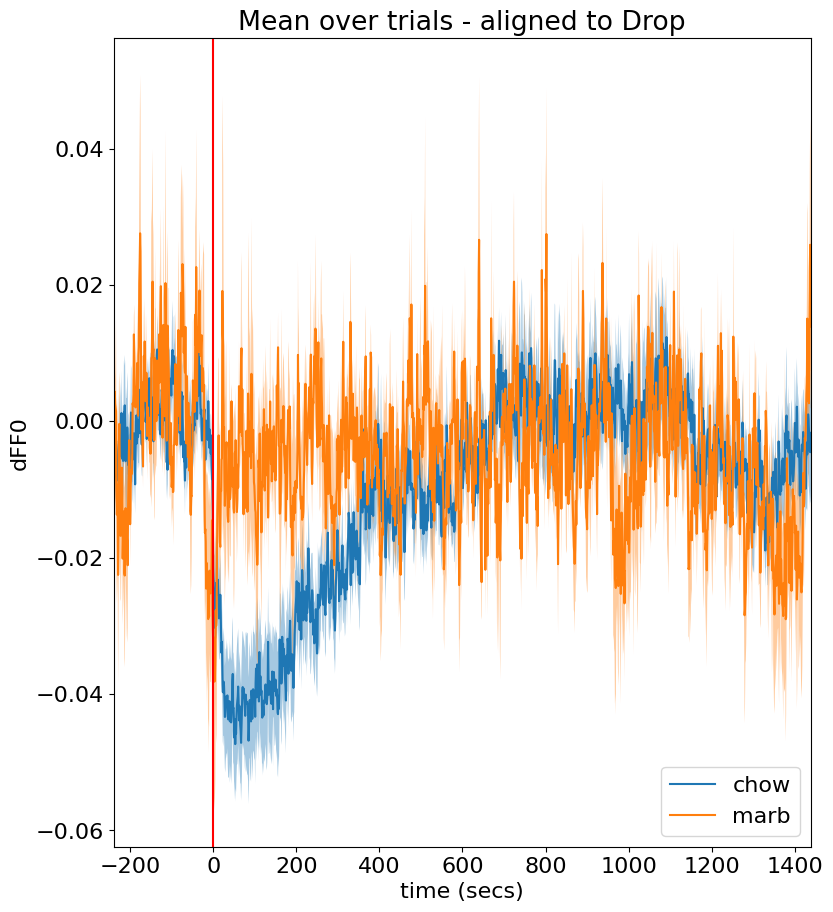

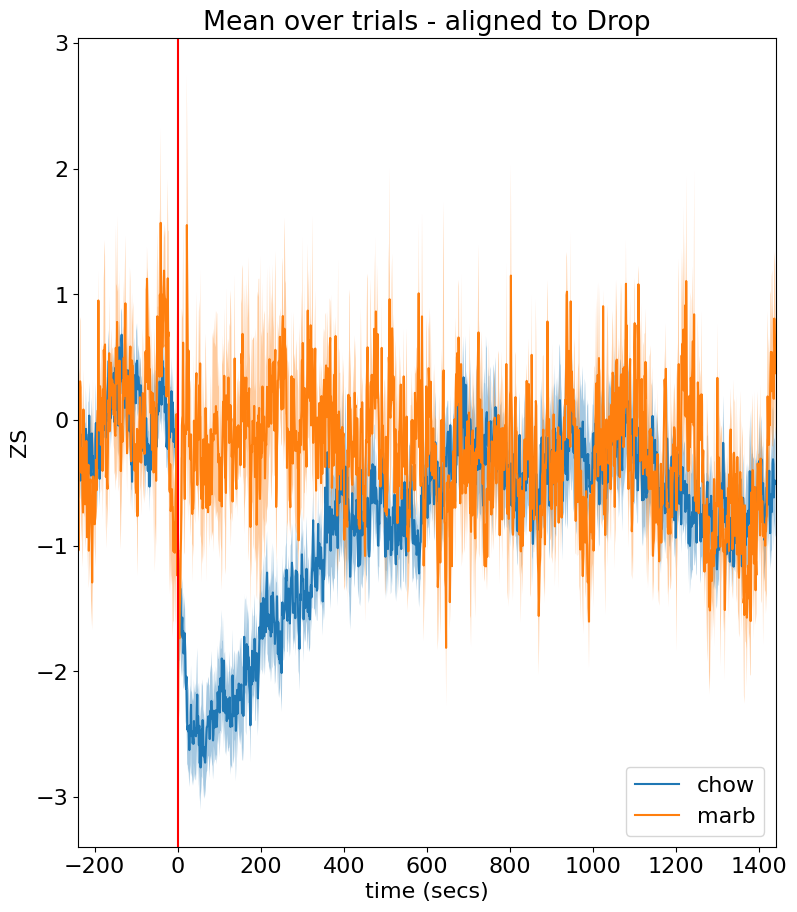

In [10]:
# Now plot dF/F0 aligned to drop
Plot_Mean_Over_Trials(Stims = StimsToPlot, Signal = 'dFF0', AlignedTo = 'Drop')
# And plot z-scored dF/F0 aligned to drop
Plot_Mean_Over_Trials(Stims = StimsToPlot, Signal = 'ZS', AlignedTo = 'Drop')

Align traces to other events (instead of when food is placed in the cage) - for instance:

1) the moment the mouse first contacts the food;

2) the first bite of food;

3) when the mouse finishes eating.

In [11]:
# Create a function to align to any given event (for both dF/F0 and z-scored dF/F0)
# takes three arguments: event is a string defining the event to be aligned to (e.g. 'Contact', 'Bite');
# event_pretime is the time before the event to be plotted (in minutes); data is the AllTrials dict created above.

# Will return all nans for trials where the given event is not annotated. If no trials are annotated for this event, will return an error.

def Align_To_Event(event, event_pretime, data = AllTrials):
    # Convert pretime to seconds
    event_pretime = event_pretime*60
    # Get number of samples from drop to event for each trial
    RelTimes = [np.nan if type(data[event+'Times'][i])==list else
                data[event+'Times'][i] - data['DropTimes'][i] 
                for i in list(range(len(data[event+'Times'])))]
    # Convert this into time given sampling rate
    data[event+'Inds'] = [round(x*data['GCaMP_corrected'].index[1],2) for x in RelTimes]

    # Find lowest length of time from event to end of trial
    # We will plot this length of time after event for every trial
    event_posttime = np.nanmin([round(np.amax(list(data['Drop_dFF0'].index))-x,2) for x in data[event+'Inds']])-1
    
    # Initialize dataframe for event-aligned traces
    event_ind = list(np.arange(0-event_pretime, event_posttime, data['GCaMP_corrected'].index[1]))
    event_ind = [round(x,2) for x in event_ind]
    my_cols = pd.MultiIndex(levels = [[],[],[]],
                            codes = [[],[],[]],
                            names = [u'MouseID',u'TrialID',u'DropWhat']
                            )
    data[event+'_dFF0'] = pd.DataFrame(index = event_ind, columns = my_cols)
    data[event+'_ZS'] = pd.DataFrame(index = event_ind, columns = my_cols)

    # Loop through trials
    for i in range(len(data[event+'Inds'])):
        EventInd = data[event+'Inds'][i]
        #get the data for this trial
        ThisTrial_dFF0 = data['Drop_dFF0'].iloc[:,i]
        ThisTrial_ZS = data['Drop_ZS'].iloc[:,i]
        cols1 = data['Drop_dFF0'].columns[i]
        # Align this trace to the event time
        AlignedTrace_dFF0 = ThisTrial_dFF0[round(EventInd-event_pretime,2):round(EventInd+event_posttime,2)]
        AlignedTrace_ZS = ThisTrial_ZS[round(EventInd-event_pretime,2):round(EventInd+event_posttime,2)]
        # Make indices relative to event time
        event_ind = [round(x-EventInd,2) for x in list(AlignedTrace_dFF0.index)]
        # Get column info (MouseID, TrialID, DropWhat)
        coldata = list(data['Drop_dFF0'].columns[i])
        cols1 = pd.MultiIndex.from_arrays([[coldata[0]],[coldata[1]],[coldata[2]]])
        # Create dataframe
        AlignedTrace_dFF0 = pd.DataFrame(list(AlignedTrace_dFF0), index = event_ind, columns = cols1)
        AlignedTrace_ZS = pd.DataFrame(list(AlignedTrace_ZS), index = event_ind, columns = cols1)
        # Add to data
        data[event+'_dFF0'] = pd.concat([data[event+'_dFF0'], AlignedTrace_dFF0], axis=1)
        data[event+'_ZS'] = pd.concat([data[event+'_ZS'], AlignedTrace_ZS], axis=1)
    
    # Now take mean over trials for each mouse, for each stimulus type
    # Initialize dataframe to contain mouse means
    my_cols = pd.MultiIndex(levels = [[],[]], codes = [[],[]],
                            names = [u'Mouse',u'Stim'])
    MouseMeans_Aligned['dFF0'][event] = pd.DataFrame(index = event_ind, columns = my_cols)
    MouseMeans_Aligned['ZS'][event] = pd.DataFrame(index = event_ind, columns = my_cols)

    for Mouse in list(set(data[event+'_dFF0'].columns.get_level_values(0))): #loop through mice
        # get trials from this mouse
        MouseTrials_dFF0 = data[event+'_dFF0'].xs(Mouse, level=0, axis=1)
        MouseTrials_ZS = data[event+'_ZS'].xs(Mouse, level=0, axis=1)
        # loop through unique stimulus IDs for this mouse
        for Stim in list(set(MouseTrials_dFF0.columns.get_level_values(1))):
            # calculate mean over trials for this mouse
            ThisMouseMean_dFF0 = pd.DataFrame(np.mean(MouseTrials_dFF0.xs(Stim, level=1, axis=1),1), 
                                                index=list(MouseTrials_dFF0.index), columns=pd.MultiIndex.from_arrays([[Mouse],[Stim]]))
            ThisMouseMean_ZS = pd.DataFrame(np.mean(MouseTrials_ZS.xs(Stim, level=1, axis=1),1),
                                                index=list(MouseTrials_ZS.index), columns=pd.MultiIndex.from_arrays([[Mouse],[Stim]]))
            # add to dataframe
            MouseMeans_Aligned['dFF0'][event] = pd.concat([MouseMeans_Aligned['dFF0'][event],ThisMouseMean_dFF0], axis=1)
            MouseMeans_Aligned['ZS'][event] = pd.concat([MouseMeans_Aligned['ZS'][event],ThisMouseMean_ZS], axis=1)

In [12]:
Align_To_Event(event = 'Contact', event_pretime = ContactPreTime) # align to first contact with food
Align_To_Event(event = 'Bite', event_pretime = BitePreTime) # align to first bite

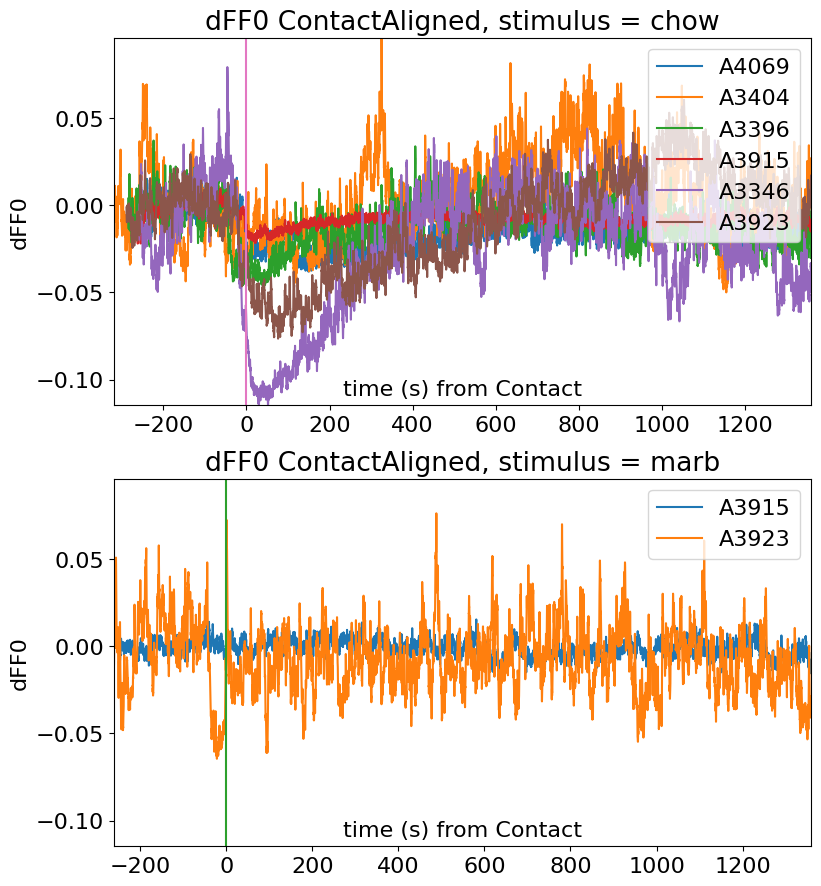

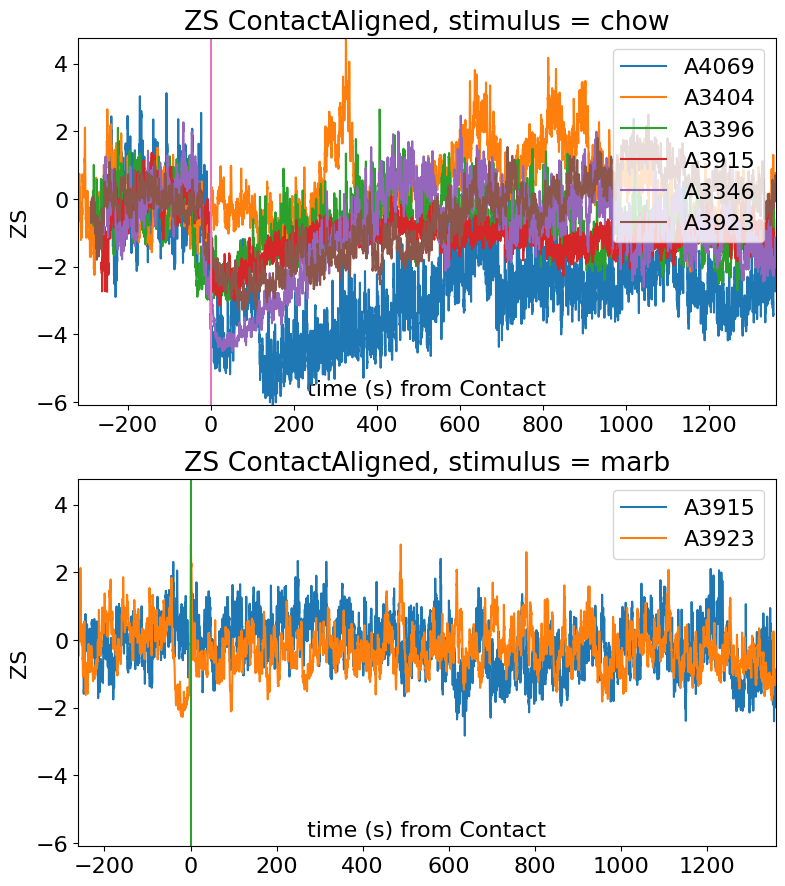

In [13]:
# Plot each mouse's mean trace aligned to contact with food
Plot_Per_Mouse(Stims = StimsToPlot, Signal = 'dFF0', AlignedTo = 'Contact')
Plot_Per_Mouse(Stims = StimsToPlot, Signal = 'ZS', AlignedTo = 'Contact')

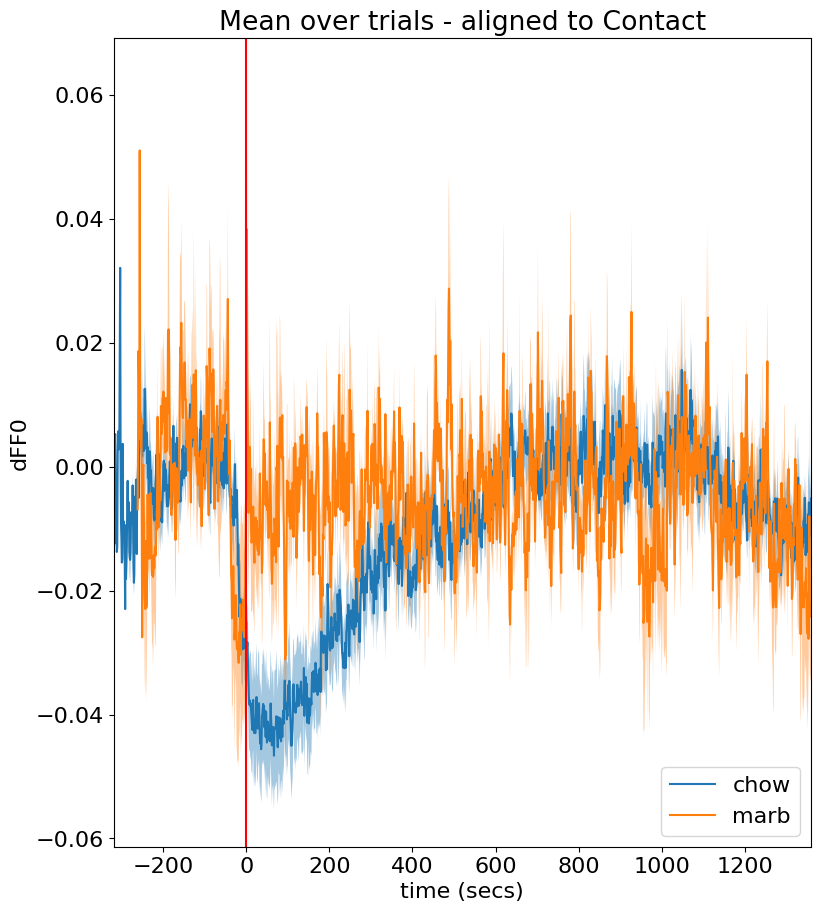

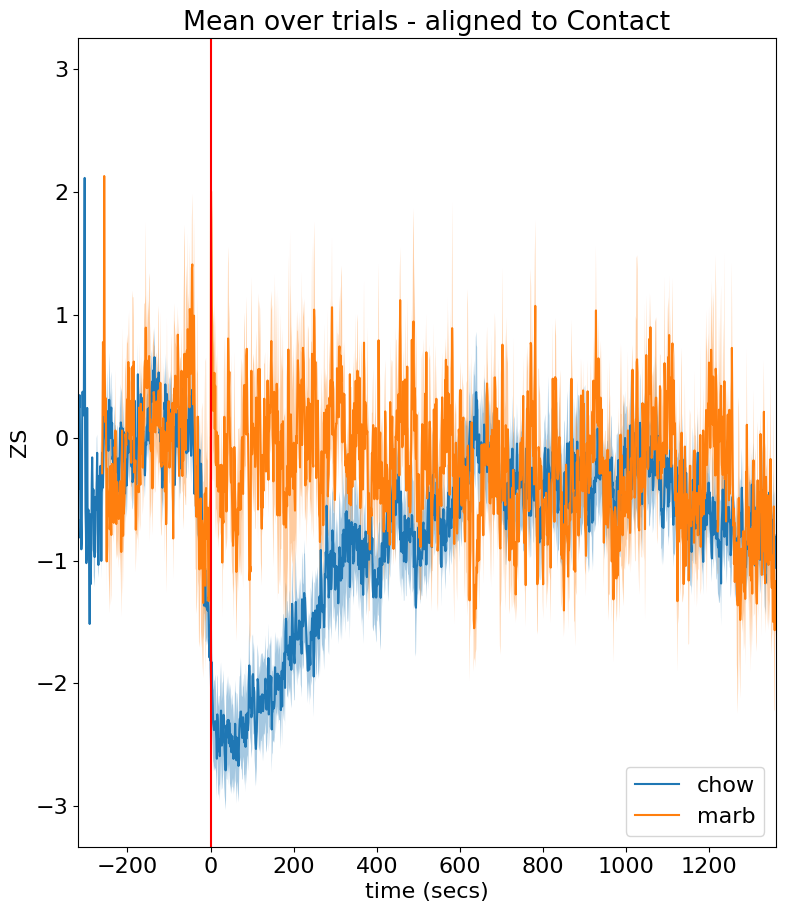

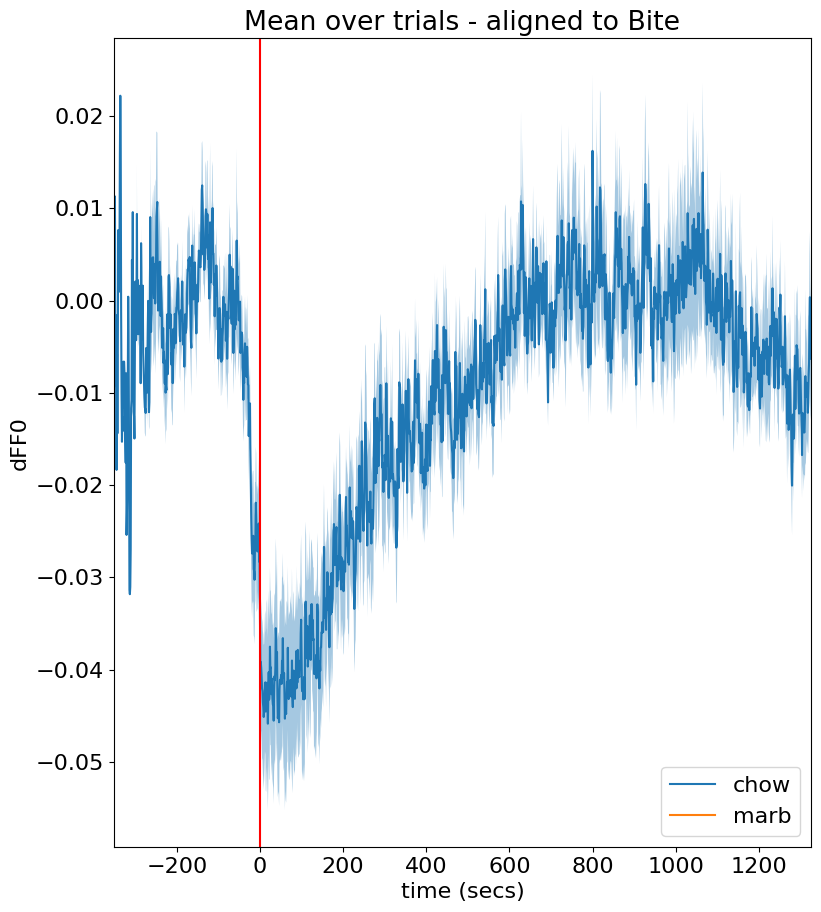

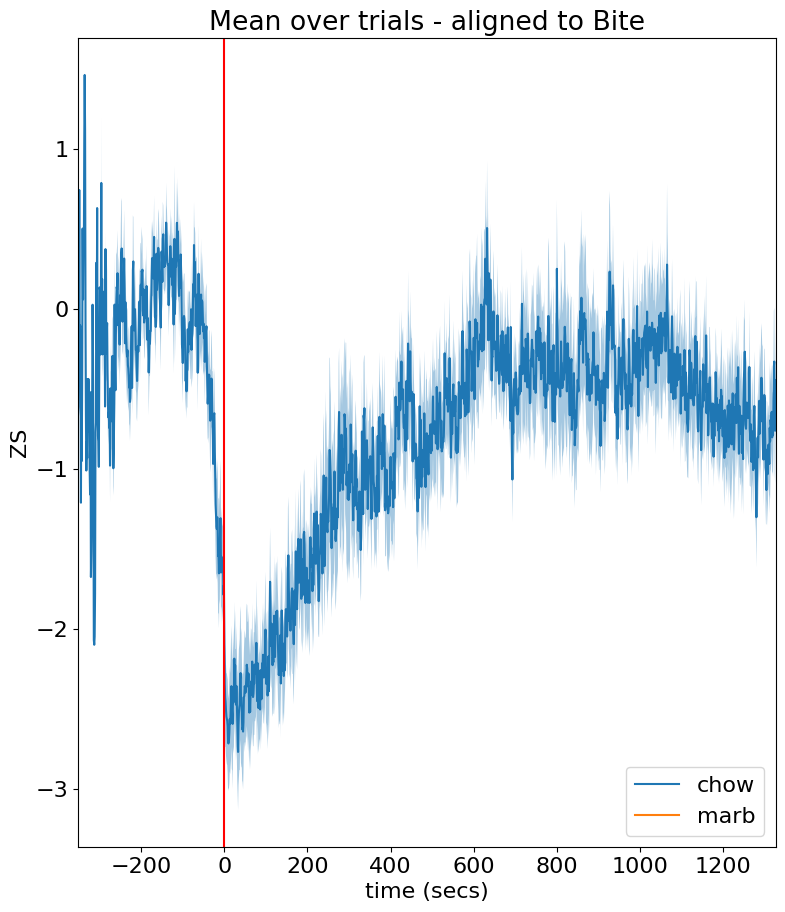

In [14]:
# Plot mean trace over trials for each stimulus aligned to 1) contact with food and 2) first bite

Plot_Mean_Over_Trials(Stims = StimsToPlot, Signal = 'dFF0', AlignedTo = 'Contact')
Plot_Mean_Over_Trials(Stims = StimsToPlot, Signal = 'ZS', AlignedTo = 'Contact')
Plot_Mean_Over_Trials(Stims = StimsToPlot, Signal = 'dFF0', AlignedTo = 'Bite')
Plot_Mean_Over_Trials(Stims = StimsToPlot, Signal = 'ZS', AlignedTo = 'Bite')

# Plot heatmap
One row for each trial, aligned to pellet drop.

In [25]:
# Create function to plot trials as a heatmap, with one row for each trial, aligned to any given event

def Plot_Heatmap(Stim, Signal, AlignedTo, TrialsData = AllTrials):
    # create figure
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    # select trials for this stimulus and transpose
    HeatMapData = AllTrials[AlignedTo+'_'+Signal].xs(Stim, level = 2, axis = 1).T
    # center color scale around 0
    divnorm = colors.TwoSlopeNorm(vmin = HeatMapData.min().min(), vcenter = 0, vmax = HeatMapData.max().max())
    # plot heatmap
    im = ax.imshow(HeatMapData,aspect='auto',interpolation='none',norm = divnorm,cmap='PiYG')
    # add x ticks & labels
    ax.set_xticks(range(0,len(HeatMapData.columns.tolist()),120*DS_rate))
    ax.set_xticklabels([str(int(i/60)) for i in HeatMapData.columns.tolist()[0:len(HeatMapData.columns.tolist()):120*DS_rate]])
    # add line at t=0
    ax.plot([np.where(HeatMapData.columns == 0)[0][0],np.where(HeatMapData.columns == 0)[0][0]],
                [-0.5,len(HeatMapData)-0.5], color='y')
    # axis properties
    ax.set(ylabel = 'trial #', xlabel = 'time (mins)', title = Signal + ' ' + AlignedTo + 'Aligned: ' + Stim)
    # colorbar
    cbar = plt.colorbar(im,ax=ax)
    cbar.set_label(Signal)


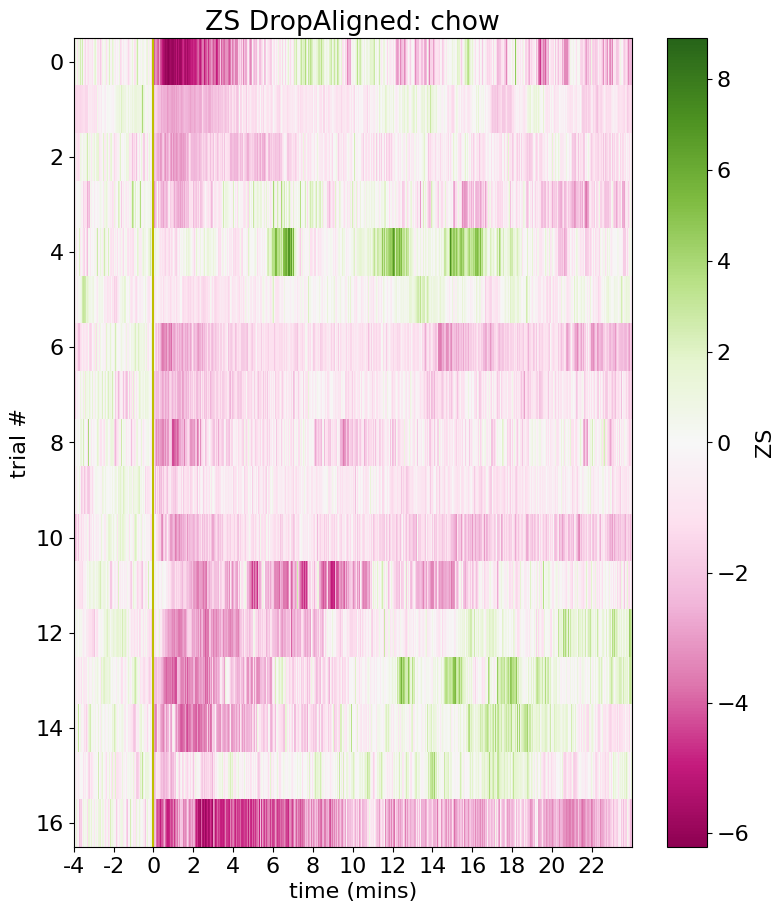

In [26]:
# plot heatmap for chow trials, aligned to pellet drop
Plot_Heatmap(Stim = 'chow', Signal = 'ZS', AlignedTo = 'Drop')

# Work in progress
Create heatmap as above, but add tick at the time of contact with food, and order trials by time from drop to contact.

In [230]:
# In progress

def Plot_Heatmap_With_Contact(TrialsData, Stim, Signal, AllData = AllTrials):
    DropToContact = [x - y for x, y in zip(AllData['ContactTimes'], AllData['DropTimes'])]
    SortedTrialsIDs = [x for _,x in sorted(zip(DropToContact,list(AllData['TrialID'])))]
    # reorder trials according to time from drop to contact
    ReIndexed = TrialsData.reindex(columns = TrialsData.columns.reindex(SortedTrialsIDs, level=1)[0])
    # now select trials for the stimulus of interest
    ReIndexed = ReIndexed.xs(Stim, level = 2, axis=1)
    # create figure
    fig= plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.pcolor(ReIndexed.T, cmap='bwr')
    ax.plot([0,0],[0,17],color='y')
    j=0



MultiIndex([('A3346', '2021-02-01-090408', 'chow', 58)],
           )